<a href="https://colab.research.google.com/github/riandongwoo/AI_tutorial_code/blob/main/2_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI-driven Materials Development

This notebook was prepared with reference to the Machine Learning course materials by Sergei V. Kalinin, University of Tennessee.

!nvidia-smi

In [73]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
!nvidia-smi

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Tue Oct 28 14:21:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   76C    P0             33W /   70W |     660MiB /  15360MiB |      0%      Default |
|                                         |                        |     

# Variational Autoencoder (VAE)




# 1. Libraries and Dataset Loading



In [74]:
#%pip uninstall -y keras

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model

import keras
from keras import ops, layers

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

# 2. Preparing the MNIST Dataset for VAE


In [75]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# 3. VAE Hyperparameters


In [76]:
# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 10

# 4. Reparameterization Trick (Sampling Layer)


In [77]:
def sampling(args):
    """Reparameterization trick by sampling
        fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    # K is the keras backend
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# 5. VAE Encoder — From Images to Latent Distributions


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 784)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 512)       │    401,920 │ encoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │      1,026 │ dense_24[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │      1,026 │ dense_24[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 403,972 (1.54 MB)

 Trainable params: 403,972 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

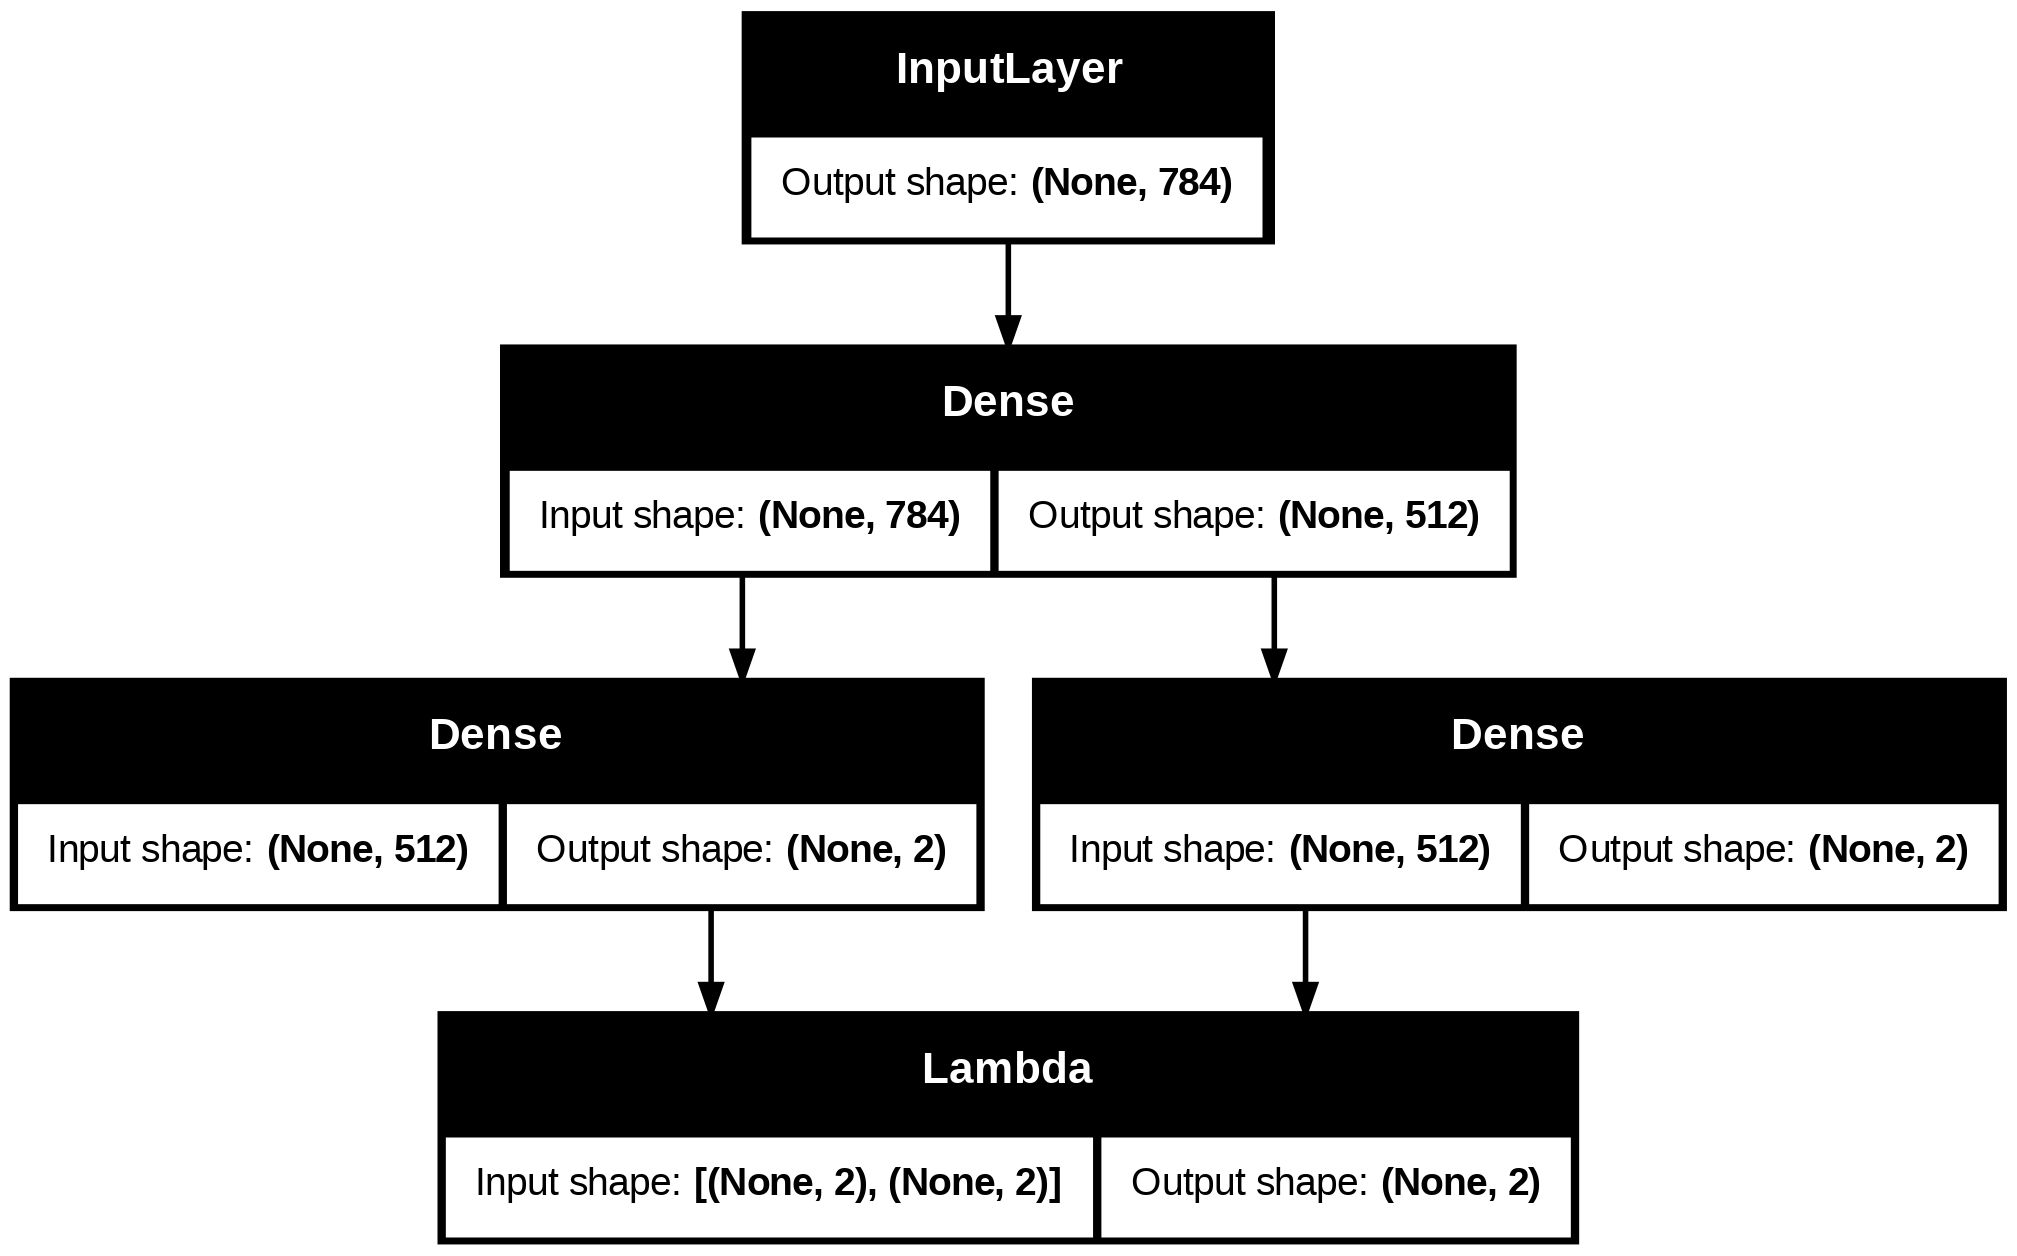

In [78]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary
# with the TensorFlow backend
z = Lambda(sampling,
           output_shape=(latent_dim,),
           name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder,
           to_file='vae_mlp_encoder.png',
           show_shapes=True)


# 6. VAE Decoder — From Latent Space Back to Images


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ z_sampling (InputLayer)         │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 512)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 784)            │       402,192 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 403,728 (1.54 MB)

 Trainable params: 403,728 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

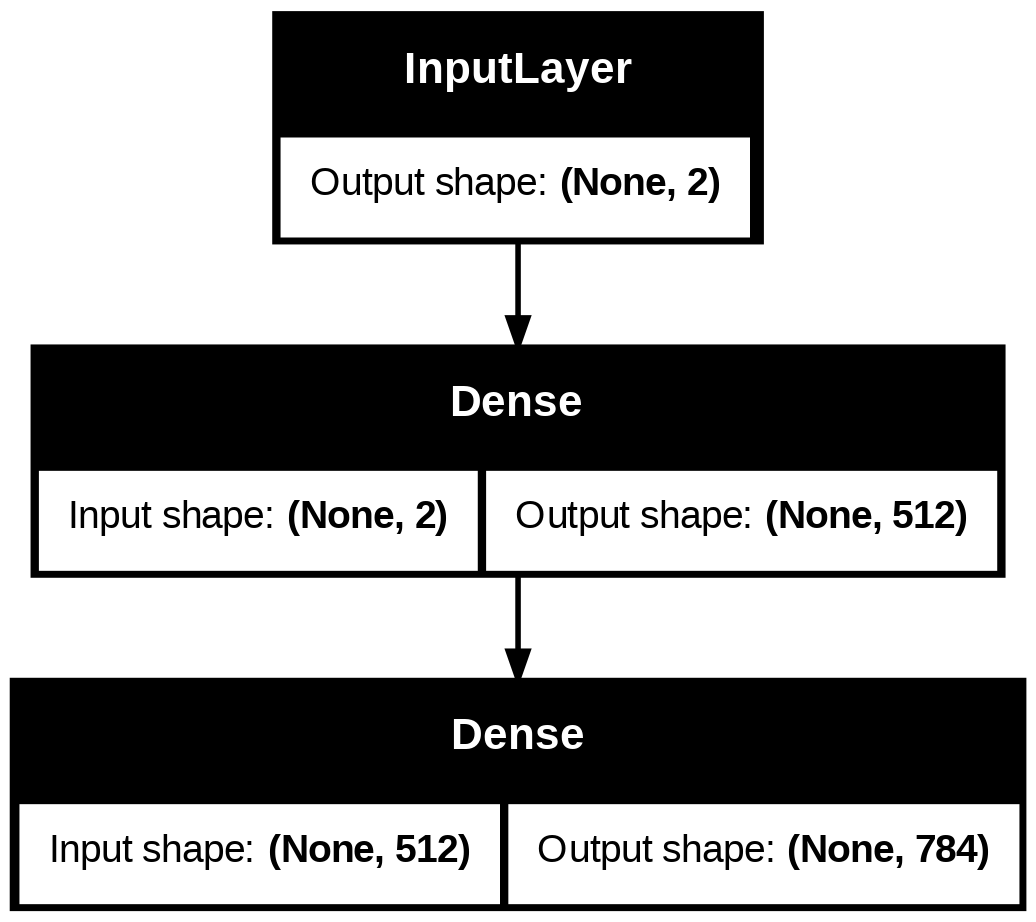

In [79]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder,
           to_file='vae_mlp_decoder.png',
           show_shapes=True)



# 7. Building the Full VAE Model


In [96]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, original_dim, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.original_dim = original_dim
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")


    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        return reconstruction

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = keras.ops.mean(
                mse(data, reconstruction)
            )
            reconstruction_loss *= self.original_dim
            kl_loss = 1 + z_log_var - keras.ops.square(z_mean) - keras.ops.exp(z_log_var)
            kl_loss = keras.ops.sum(kl_loss, axis=-1)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + keras.ops.mean(kl_loss) # Added mean here as well

        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(keras.ops.mean(kl_loss)) # Added mean here
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        reconstruction_loss = keras.ops.mean(
            mse(data, reconstruction)
        )
        reconstruction_loss *= self.original_dim
        kl_loss = 1 + z_log_var - keras.ops.square(z_mean) - keras.ops.exp(z_log_var)
        kl_loss = keras.ops.sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        total_loss = reconstruction_loss + keras.ops.mean(kl_loss) # Added mean here as well

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(keras.ops.mean(kl_loss)) # Added mean here
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [98]:
# Instantiate the custom VAE model
vae = VAE(encoder, decoder, original_dim)

# Compile the VAE model
vae.compile(optimizer='adam')

# Display the model summary
vae.summary()

Model: "vae_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ [(None, 2), (None, 2), │       403,972 │
│                                 │ (None, 2)]             │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 784)            │       403,728 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 807,700 (3.08 MB)

 Trainable params: 807,700 (3.08 MB)

 Non-trainable params: 0 (0.00 B)

# 8. Training the VAE


In [99]:
vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - kl_loss: 5.7933 - loss: 66.2755 - reconstruction_loss: 60.4822 - val_kl_loss: 2.9753 - val_loss: 44.1103 - val_reconstruction_loss: 41.1349
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 2.9645 - loss: 43.9266 - reconstruction_loss: 40.9622 - val_kl_loss: 3.2321 - val_loss: 42.8355 - val_reconstruction_loss: 39.6034
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 3.2208 - loss: 42.7851 - reconstruction_loss: 39.5643 - val_kl_loss: 3.4166 - val_loss: 42.0981 - val_reconstruction_loss: 38.6814
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss: 3.3917 - loss: 42.0178 - reconstruction_loss: 38.6261 - val_kl_loss: 3.3972 - val_loss: 41.4461 - val_reconstruction_loss: 38.0490
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 3.5485 - loss: 41.3364 - reconstruction_loss: 37.7879 - val_kl_loss: 3.6886 - val_loss: 40.8221 - val_reconstruction_loss: 37.1335
Epoch 6/10
469/469 ━━━━━━━━━━━

# 9. Visualizing Original Test Images


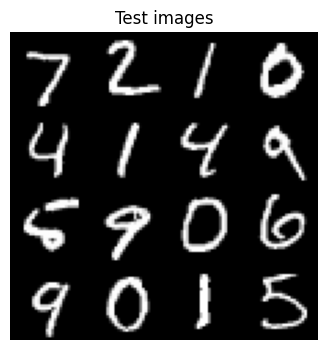

In [100]:
def show_grid(imgs, grid=(4,4), fname=None, title=None, image_size=28):
    imgs = np.asarray(imgs)

    # (N, H, W, 1) -> (N, H, W)
    if imgs.ndim == 4 and imgs.shape[-1] == 1:
        imgs = imgs[..., 0]

    # (N, 784) -> (N, 28, 28)
    if imgs.ndim == 2 and imgs.shape[1] == image_size * image_size:
        imgs = imgs.reshape(-1, image_size, image_size)

    # 최소 (N,H,W) 보장
    if imgs.ndim != 3:
        raise ValueError(f"Expected (N,H,W) or (N,H,W,1) or (N,{image_size*image_size}), got {imgs.shape}")

    r, c = grid
    N, H, W = imgs.shape
    assert r * c <= N, f"grid {grid} requires at least {r*c} images, got {N}"

    canvas = np.vstack([
        np.hstack([imgs[i*c + j] for j in range(c)])
        for i in range(r)
    ])

    plt.figure(figsize=(c, r))
    plt.axis('off')
    if title: plt.title(title)
    plt.imshow(canvas, cmap='gray', vmin=0, vmax=1)
    if fname:
        plt.savefig(fname, bbox_inches='tight', pad_inches=0)
    plt.show()
show_grid(x_test[:16], grid=(4,4), title='Test images')

# 10. Reconstructed Images from the VAE



40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


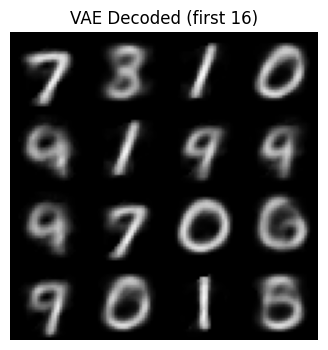

In [101]:
x_decoded = vae.predict(x_test, batch_size=256)
show_grid(x_decoded[:16], grid=(4,4), fname='vae_decoded.png', title='VAE Decoded (first 16)')

# Practice: Tune VAE Hyperparameters

In this section, we experiment with different hyperparameters of the Variational Autoencoder and observe how they affect the reconstruction quality and latent space structure.

We encourage you to run multiple settings and compare your results!


| Hyperparameter   | Description                               | Suggested Values       | Expected Effect |
|-----------------|-------------------------------------------|------------------------|----------------|
| intermediate_dim | Size of the hidden (dense) layer          | 256 / 512 / 1024       | Larger → more expressive encoder/decoder → clearer reconstructions |
| batch_size       | Number of samples per gradient update     | 64 / 128 / 256         | Smaller → noisy updates, maybe better generalization but slower |
| latent_dim       | Dimensionality of the latent space        | 2 / 8 / 16             | Larger → more information preserved → better reconstructions but harder to visualize |
| epochs           | Number of training iterations             | 20 / 40 / 60           | Longer → more convergence → reduced reconstruction error |

### **Submit the following as your practice result:

•	Reconstructed digit images showing successful generation of MNIST test data using VAE

•	The hyperparameter set (intermediate_dim / batch_size / latent_dim / epochs) that produced the shown results

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 784)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 1024)      │    803,840 │ encoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 16)        │     16,400 │ dense_30[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 16)        │     16,400 │ dense_30[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 16)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 836,640 (3.19 MB)

 Trainable params: 836,640 (3.19 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ z_sampling (InputLayer)         │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1024)           │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 784)            │       803,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 821,008 (3.13 MB)

 Trainable params: 821,008 (3.13 MB)

 Non-trainable params: 0 (0.00 B)

Model: "vae_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ ((None, 16), (None,    │       836,640 │
│                                 │ 16), (None, 16))       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 784)            │       821,008 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,657,648 (6.32 MB)

 Trainable params: 1,657,648 (6.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - kl_loss: 7.1532 - loss: 49.1064 - reconstruction_loss: 41.9532 - val_kl_loss: 9.9688 - val_loss: 33.3279 - val_reconstruction_loss: 23.3590
Epoch 2/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - kl_loss: 10.8449 - loss: 32.9912 - reconstruction_loss: 22.1463 - val_kl_loss: 11.6398 - val_loss: 31.7198 - val_reconstruction_loss: 20.0800
Epoch 3/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - kl_loss: 11.5637 - loss: 31.7959 - reconstruction_loss: 20.2322 - val_kl_loss: 11.9739 - val_loss: 30.9908 - val_reconstruction_loss: 19.0169
Epoch 4/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - kl_loss: 11.8505 - loss: 31.2377 - reconstruction_loss: 19.3873 - val_kl_loss: 11.8575 - val_loss: 30.6373 - val_reconstruction_loss: 18.7798
Epoch 5/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - kl_loss: 12.0174 - loss: 30.8828 - reconstruction_loss: 18.8654 - val_kl_loss: 11.8969 - val_loss: 30.2626 - val_reconstruction_loss: 18.3657
Epoch 6/40
938/938 ━━━

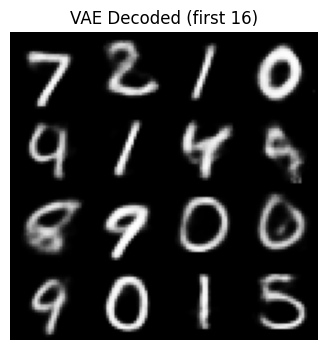

In [103]:
# You can change these parameters and see how the results differ
intermediate_dim = 1024  # 256, 512, 1024
batch_size = 64        # 32, 64, 256
latent_dim = 16          # 2, 8, 16
epochs = 40             # 10 ~

# Don't change this part
#------------------------------------------------------------------#
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary
# with the TensorFlow backend
z = Lambda(sampling,
           output_shape=(latent_dim,),
           name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder,
           to_file='vae_mlp_encoder.png',
           show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder,
           to_file='vae_mlp_decoder.png',
           show_shapes=True)

# Instantiate the custom VAE model
vae = VAE(encoder, decoder, original_dim)

# Compile the VAE model
vae.compile(optimizer='adam')

# Display the model summary
vae.summary()

vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

x_decoded = vae.predict(x_test, batch_size=256)
show_grid(x_decoded[:16], grid=(4,4),
          fname='vae_decoded.png',
          title='VAE Decoded (first 16)')
#------------------------------------------------------------------


# Visualizing the VAE Latent Space

To examine how the VAE organizes digit representations, we encode the test images into the 2-D latent space using the encoder’s output mean (z_mean).

This plot shows:

•	Each point represents a test digit projected into the latent space

•	Colors correspond to digit labels (0–9)

•	Similar digits tend to cluster together

•	Different digits spread across distinct regions

This visualization demonstrates that the VAE has learned a structured, continuous latent representation that organizes the MNIST digit variations meaningfully.

In [ ]:
def plot_latent_distribution(data, labels, encoder):
    """
    Plots the latent distribution of the data using a 2D latent space.

    Parameters:
    - data: The input data to encode and plot.
    - encoder: The encoder model with a `predict` method that encodes data into a 2D latent space.
    """

    # Use the encoder to transform the data into the latent space
    latent_variables, _, _ = encoder.predict(data, batch_size=batch_size)

    # Check if the latent space is 2D
    if latent_variables.shape[1] != 2:
        raise ValueError("The latent space is not 2D.")

    # Plotting the latent space distribution
    plt.figure(figsize=(8, 8))
    plt.scatter(latent_variables[:, 0], latent_variables[:, 1], c = labels, alpha=0.7)
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('Latent Space Distribution')
    plt.grid(True)
    plt.show()
plot_latent_distribution(x_test, y_test, encoder)

157/157 [==============================] - 0s 1ms/step


ValueError: The latent space is not 2D.

24/24 [==============================] - 0s 2ms/step


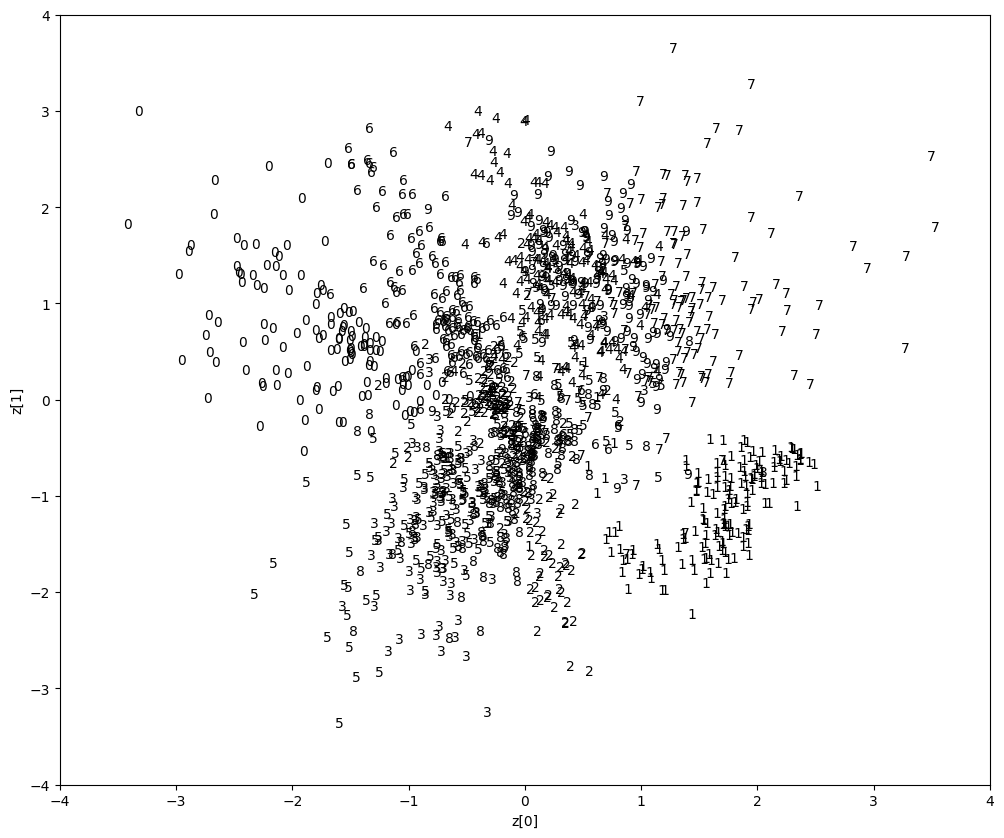

1/1 [==============================] - 0s 11ms/step


KeyboardInterrupt: 

In [ ]:
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as function
        of 2-dim latent vector
    # Arguments:
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    xmin = ymin = -4
    xmax = ymax = +4
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z, _, _ = encoder.predict(x_test,
                              batch_size=batch_size)
    plt.figure(figsize=(12, 10))

    # axes x and y ranges
    axes = plt.gca()
    axes.set_xlim([xmin,xmax])
    axes.set_ylim([ymin,ymax])

    # subsample to reduce density of points on the plot
    z = z[0::2]
    y_test = y_test[0::2]
    plt.scatter(z[:, 0], z[:, 1], marker="")
    for i, digit in enumerate(y_test):
        axes.annotate(digit, (z[i, 0], z[i, 1]))
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()
models = (encoder, decoder)
data = (x_test[:3000], y_test[:3000])
plot_results(models,
                data,
                batch_size=batch_size,
                model_name="vae_mlp")

In [ ]:
x_test.shape

(10000, 784)

1/1 [==============================] - 0s 10ms/step


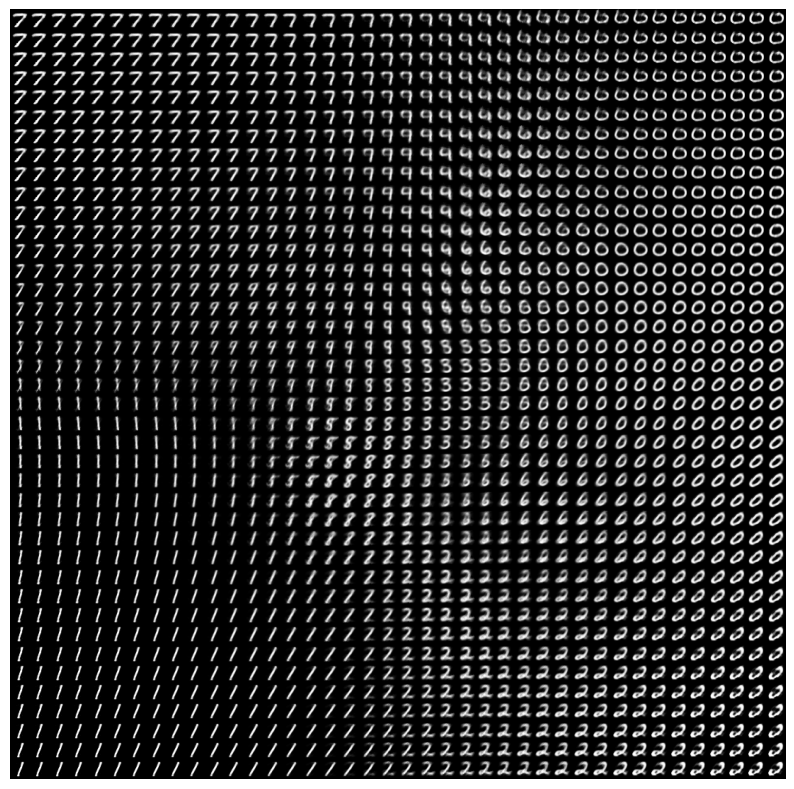

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_latent_space(decoder, num_samples=10, grid_range=3, image_size=(28, 28)):
    """
    Generates a grid of images decoded from latent space points.

    Parameters:
    - decoder: The decoder model that decodes latent points into images.
    - num_samples: The number of images per dimension in the grid.
    - grid_range: The range of values in each dimension of the latent space grid.
    - image_size: A tuple (height, width) of the images.
    """

    # Linearly spaced coordinates corresponding to the 2D grid
    grid_x = np.linspace(-grid_range, grid_range, num_samples)
    grid_y = np.linspace(-grid_range, grid_range, num_samples)

    # Create a figure with subplots
    figure, axes = plt.subplots(num_samples, num_samples, figsize=(10, 10))

    # Remove inner axes numbers
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])

    # Plotting the grid
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample);
            img = x_decoded[0].reshape(image_size)  # Adjust the shape based on your data
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].axis('off')

    # Adjust the spacing between plots
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
plot_latent_space(decoder, num_samples=40, grid_range=3, image_size=(28, 28))